In [129]:
import time
deltas = []
for _ in range(5):
    t1 =time.perf_counter()
    !python main.py --verbose 1
    deltas.append(time.perf_counter()-t1)

Dataset StarLightCurves loading from cache 

Computing all shapelets...
Computing shapelet 1/9
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for
more info.)
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 2/9
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 3/9
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 4/9
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 5/9
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 6/9
         Computing collision table...
         Computing distances 
         Finding best shapelet 
Computing shapelet 7/9
         Computing collision table...
         Computing distances 
      

In [130]:
print(np.mean(deltas), np.std(deltas))

922.1787870158441 20.877340264888783


In [3]:
import sys 
import os

if 'fast_shapelets' not in [el.split('/')[-1] for el in sys.path]:
    curr_path = os.getcwd()
    sys.path.append('/'.join((curr_path.split('/')[:-1])))




In [98]:
from src import get_dataset, FastShapelets
import numpy as np
import matplotlib.pyplot as plt
from src._utils import DTW_distance


# Load data

In [5]:
X_train,y_train, X_test, y_test = get_dataset('StarLightCurves')
y_train = y_train-1
y_test = y_test-1

Dataset StarLightCurves loading from cache 



# Binary classification

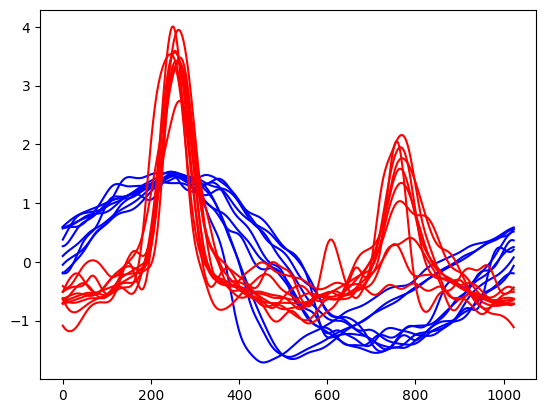

In [6]:
class_0 = X_train[np.where(y_train==0)][:10]
class_2 = X_train[np.where(y_train==1)][:10]
for el in class_0:
  plt.plot(el,color='b')
for el in class_2:
  plt.plot(el,color='r')


In [15]:
train_bin_indices = (y_train ==1) + (y_train ==0)
test_bin_indices = (y_test ==1) + (y_test ==0)

In [16]:
X_train_bin, y_train_bin = X_train[train_bin_indices], y_train[train_bin_indices]
X_test_bin, y_test_bin = X_test[test_bin_indices], y_test[test_bin_indices]

In [100]:
shapelets_len = list(range(100, 600, 50))

In [101]:
fs = FastShapelets(shapelet_lengths =shapelets_len,  cardinality=4, dimensionality=16, r=10, n_jobs=1)

In [102]:
fs.fit(X_train_bin, y_train_bin, dist_shapelet =DTW_distance)

Output()

Computing all shapelets...

Computing shapelet 1/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 2/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 3/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 4/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 5/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 6/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 7/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 8/10

Computing collision table...

Computing distances

Computing shapelet 9/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 10/10

Computing collision table...

Computing distances

Finding best shapelet

In [103]:
import pickle
with open('shap_100_600_50_bin_dtw.pkl', 'wb') as f :
    pickle.dump(fs.get_shapelets(), f)

In [123]:
with open('shap_100_600_50_bin_dtw.pkl', 'rb') as f :
    fs.fit(shapelets = pickle.load(f))

In [115]:
train_shap = fs.transform(X_train_bin)
test_shap = fs.transform(X_test_bin)

In [125]:
#with open('train_shap_bin_dtw.pkl', 'wb') as f :
#    pickle.dump(train_shap, f)
#with open('test_shap_bin_dtw.pkl', 'wb') as f :
#    pickle.dump(test_shap, f)

with open('train_shap_bin_dtw.pkl', 'rb') as f :
    train_shap = pickle.load(f)
with open('test_shap_bin_dtw.pkl', 'rb') as f :
    test_shap = pickle.load(f)

EOFError: Ran out of input

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_shap, y_train_bin)
acc = knn.score(test_shap,y_test_bin)
b_acc = balanced_accuracy_score(y_test_bin, knn.predict(test_shap))
print(f"raw acc : {acc} | balanced acc {b_acc}")

raw acc : 0.9985640436530729 | balanced acc 0.9987075122051909


0.988799540493969


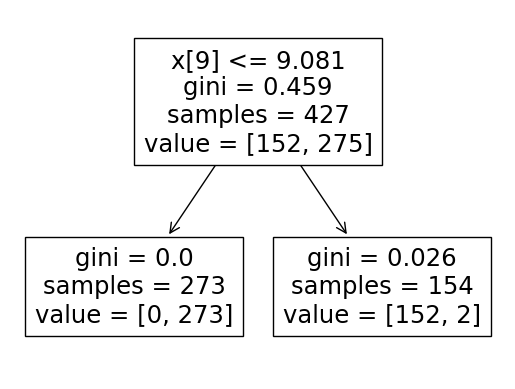

In [107]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=1)
Dtree.fit(train_shap, y_train_bin)
print(Dtree.score(test_shap,y_test_bin))
tree.plot_tree(Dtree)
plt.savefig('bin_tree.png')

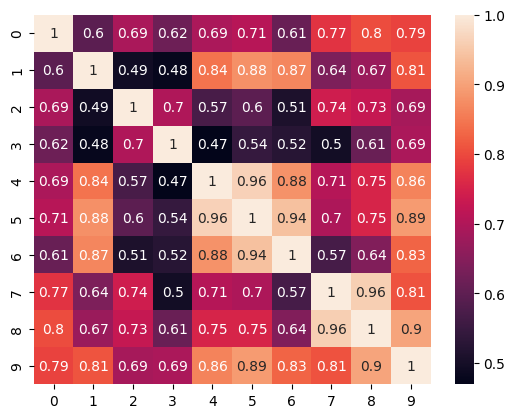

In [110]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

train_features_df = pd.DataFrame(train_shap)

corr_matrix = train_features_df.corr()
fig = sn.heatmap(corr_matrix,annot=True)
plt.savefig('heatmap_bin.png')
plt.show()

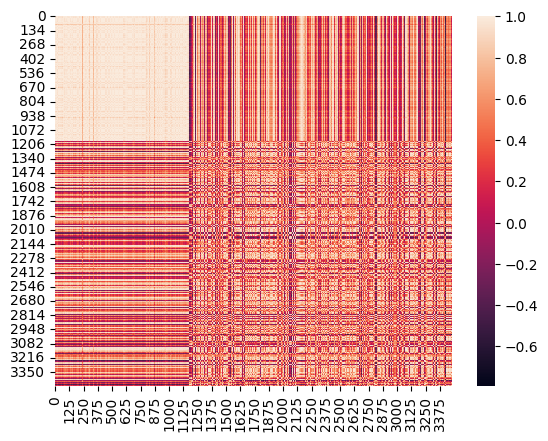

In [95]:
ind_df = pd.DataFrame(test_shap[np.argsort(y_test_bin)].T)

corr_ind = ind_df.corr()
sn.heatmap(corr_ind)
plt.savefig('heat')
plt.show()

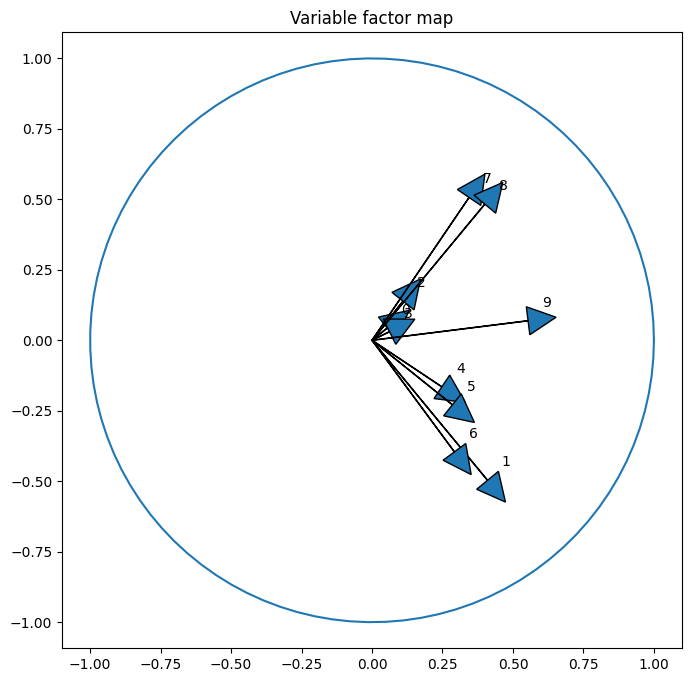

In [113]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
df = train_features_df
 
n_components = 10
 
# Do the PCA.
pca = PCA(n_components=n_components)
pca.fit_transform(df)


# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.savefig('bin_circular.png')
plt.show()

In [33]:
print([fs.shapelets[k].gain for k in fs.shapelets.keys()])

[-0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425, -0.0014888525986428425]


In [53]:
from src._shapelet import Shapelet

In [85]:
fs.fit(shapelets={i:Shapelet(value=sh) for i,sh in enumerate(shaps)})

In [41]:
with open('shap_100_600_50_bin.pkl', 'rb') as f :
    shapelets=pickle.load(f)
    
fs = FastShapelets().fit(shapelets=shapelets)

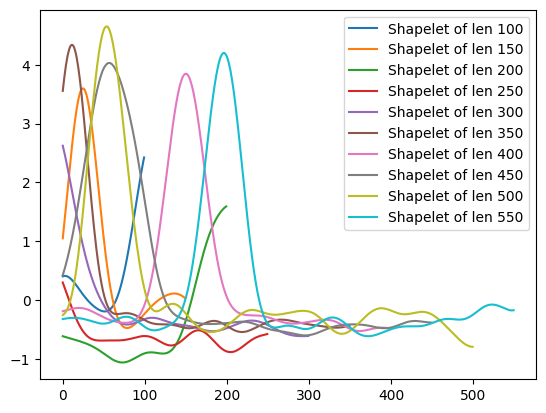

In [117]:
for i,k in enumerate(fs.shapelets.keys()):
  plt.plot(fs.shapelets[k].value,label=f"Shapelet of len {k}")
  plt.legend()
    
plt.savefig('shap_bin.png')

# Stability

In [119]:
shaps = []
for k in range(10):
  fs = FastShapelets(min_shapelet_length=450, max_shapelet_length=451, cardinality=4, dimensionality=16, r=10, n_jobs=1)
  fs.fit(X_train_bin,y_train_bin)
  shaps.append(fs.shapelets[450].value)
plt.savefig('shap_stab.png')

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

Output()

Computing all shapelets...

Computing shapelet 1/1

Computing collision table...

Computing distances

Finding best shapelet

<Figure size 640x480 with 0 Axes>

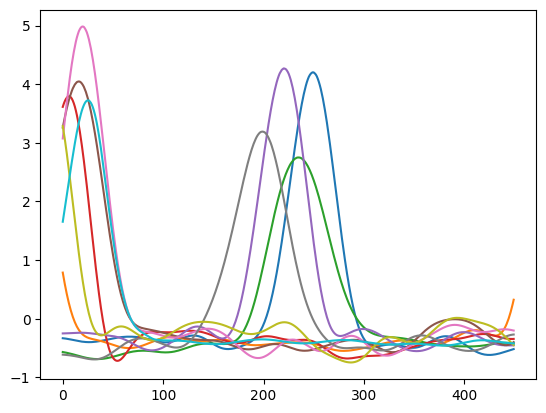

In [122]:
for shap in shaps:
    plt.plot(shap)
    
plt.savefig('shap_stab.png')


In [120]:
with open('shap_stab_450_bin.pkl', 'wb') as f :
    pickle.dump({i:Shapelet(value=sh) for i,sh in enumerate(shaps)}, f)

# 3 class

In [67]:
train_tern_indices = train_bin_indices + (y_train==2)
test_tern_indices = test_bin_indices + (y_test==2)
X_train_tern, y_train_tern = X_train[train_tern_indices], y_train[train_tern_indices]
X_test_tern, y_test_tern = X_test[test_tern_indices], y_test[test_tern_indices]


In [71]:
fs = FastShapelets(shapelet_lengths = shapelets_len, cardinality=4, dimensionality=16, r=10, n_jobs=1)

In [72]:
fs.fit(X_train_tern,y_train_tern)

Output()

Computing all shapelets...

Computing shapelet 1/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 2/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 3/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 4/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 5/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 6/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 7/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 8/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 9/10

Computing collision table...

Computing distances

Finding best shapelet

Computing shapelet 10/10

Computing collision table...

Computing distances

Finding best shapelet

In [73]:
import pickle
with open('shap_100_600_50_tern.pkl', 'wb') as f :
    pickle.dump(fs.get_shapelets(), f)

In [ ]:
with open('shap_100_600_50_tern.pkl', 'rb') as f :
    fs.fit(shapelets = pickle.load(f))

In [74]:
train_shap_tern = fs.transform(X_train_tern)
test_shap_tern = fs.transform(X_test_tern)

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_shap_tern, y_train_tern)
acc = knn.score(test_shap_tern,y_test_tern)
b_acc = balanced_accuracy_score(y_test_tern, knn.predict(test_shap_tern))
print(f"raw acc : {acc} | balanced acc {b_acc}")

raw acc : 0.932491500728509 | balanced acc 0.9262712964838595


0.8550267119961146


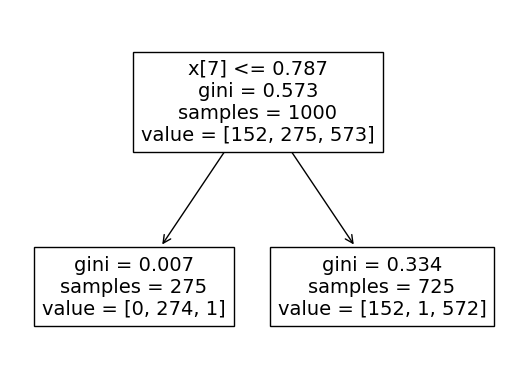

In [81]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=1)
Dtree.fit(train_shap_tern, y_train_tern)
print(Dtree.score(test_shap_tern,y_test_tern))
tree.plot_tree(Dtree)
plt.savefig('tree_tern.png')

Confusion matrix without normalization
[[1015    0  162]
 [   1 2302    2]
 [ 391    0 4363]]
Normalized confusion matrix
[[8.62361937e-01 0.00000000e+00 1.37638063e-01]
 [4.33839479e-04 9.98698482e-01 8.67678959e-04]
 [8.22465292e-02 0.00000000e+00 9.17753471e-01]]


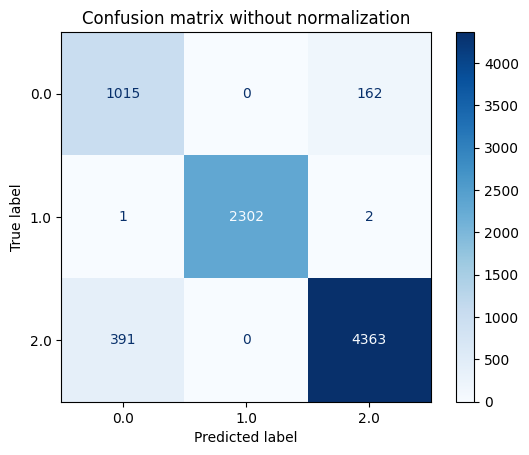

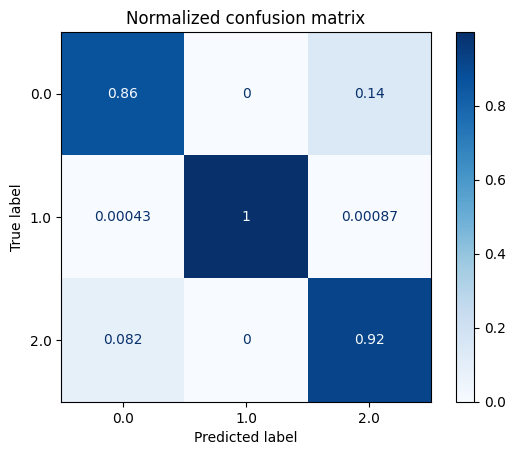

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        knn,
        test_shap_tern,
        y_test_tern,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.savefig("_".join(title.split()[:2])+".png")
plt.show()


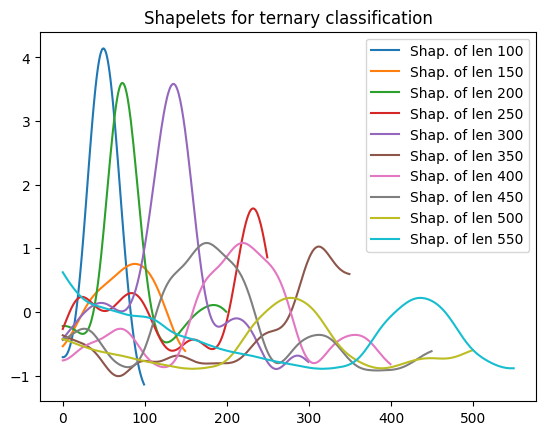

In [84]:
for i,k in enumerate(fs.shapelets.keys()):
    plt.plot(fs.shapelets[k].value,label=f"Shap. of len {k}")
    plt.title('Shapelets for ternary classification')
    plt.legend()
    plt.savefig('shap_tern.png')

In [ ]:
from sklearn import tree
Dtree = DecisionTreeClassifier(max_depth=2)
Dtree.fit(train_shap, np.hstack((np.zeros(10),np.ones(10))))
print(Dtree.score(test_shap,np.hstack((np.zeros(1177),np.ones(2305)))))
tree.plot_tree(Dtree)